In [1]:
import psycopg2
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
import psycopg2

conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres",
    password="postgres"
)

cur = conn.cursor()

cur.execute("SELECT version();")
print(cur.fetchone())

('PostgreSQL 15.2, compiled by Visual C++ build 1914, 64-bit',)


In [54]:
# Connect to db
conn = psycopg2.connect(host='localhost', dbname='mimic', user='postgres', password='postgres', options='-c search_path=mimiciii')
#conn = psycopg2.connect(dbname='mimic', user='postgres')
cur = conn.cursor() 

# Read in table with patients & admissions (inner join on subject_id) and icu_stays (inner joinon subject_id and hadm_id)
icustay_details = pd.read_sql_query("SELECT * FROM mimiciii.flicu_icustay_detail;", conn)

# Read in vital signs
#pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)

# Read in lab measurements
# Use flicu_pivoted_lab (as it only takes the lab tests during ICU stay)
#query = "SELECT * FROM mimiciii.flicu_pivoted_lab;"
# Alternative:  Use the lab values recorded previous to the ICU stay (although during same hospital admission!), 
# then sample them  (8h intervalls) and then forward fill plus cap at either icu admission time of first vital sign recorded
#query = "SELECT * FROM mimiciii.pivoted_lab;"
#pivoted_lab = pd.read_sql_query(query, conn)

# Close the cursor and connection to so the server can allocate bandwidth to other requests


In [63]:
icustay_details.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'admission_age', 'ethnicity',
       'ethnicity_grouped', 'hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq',
       'diagnoses_icd'],
      dtype='object')

In [64]:
icustay_details.head()

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,diagnoses_icd
0,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,3.863889,0.002434,ASIAN,asian,0,1,True,2138-07-17 21:20:07,2138-07-17 23:32:21,0.091829,1,"[V3001, V053, V290]"
1,3,145834,211552,M,2102-06-14,2101-10-20 19:08:00,2101-10-31 13:58:00,10.784722,76.526792,WHITE,white,0,1,True,2101-10-20 19:10:11,2101-10-26 20:43:09,6.064560,1,"[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
2,4,185777,294638,F,NaT,2191-03-16 00:28:00,2191-03-23 18:41:00,7.759028,47.845047,WHITE,white,0,1,True,2191-03-16 00:29:31,2191-03-17 16:46:31,1.678472,1,"[042, 1363, 7994, 2763, 7907, 5715, 04111, V09..."
3,5,178980,214757,M,NaT,2103-02-02 04:31:00,2103-02-04 12:15:00,2.322222,0.000693,ASIAN,asian,0,1,True,2103-02-02 06:04:24,2103-02-02 08:06:00,0.084444,1,"[V3000, V053, V290]"
4,6,107064,228232,F,NaT,2175-05-30 07:15:00,2175-06-15 16:00:00,16.364583,65.942297,WHITE,white,0,1,True,2175-05-30 21:30:54,2175-06-03 13:39:54,3.672917,1,"[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."


In [65]:
icustay_details['ethnicity_grouped'].value_counts()

white       42833
unknown      6173
black        5955
hispanic     2191
asian        2024
other        1818
native         57
Name: ethnicity_grouped, dtype: int64

In [66]:
icustay_details['hadm_id'].value_counts()

186706    7
163281    7
175448    6
123178    6
109520    6
         ..
134982    1
126404    1
137495    1
110782    1
113369    1
Name: hadm_id, Length: 57328, dtype: int64

In [67]:
icustay_details[icustay_details['subject_id']==85]

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,diagnoses_icd
88,85,116630,209562,M,2167-09-12,2162-03-02 14:04:00,2162-03-10 13:15:00,7.965972,71.455485,WHITE,white,0,1,True,2162-03-03 13:03:47,2162-03-05 18:42:39,2.235324,1,"[4241, 20280, V4282, 99811, 3320, 30000, 53081..."
89,85,112077,291697,M,2167-09-12,2167-07-25 18:49:00,2167-07-30 15:24:00,4.857639,76.849829,WHITE,white,0,2,False,2167-07-25 18:50:37,2167-07-27 18:37:35,1.990949,1,"[0389, 486, V4281, 23875, 42731, 41400, 3004, ..."


In [68]:
icustay_details['CKD'] = icustay_details['diagnoses_icd'].apply(lambda x: any(code in ['5851', '5852', '5853', '5854', '5855', '5859'] for code in x))

In [69]:
icustay_details['CKD_stage'] = icustay_details['diagnoses_icd'].apply(lambda x: next((stage for code, stage in [('5851', 'CKD1'), ('5852', 'CKD2'), ('5853', 'CKD3'), ('5854', 'CKD4'), ('5855', 'CKD5'), ('5859', 'CKD')] if code in x), None))

In [70]:
icustay_details[icustay_details['subject_id']==85]

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,...,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,diagnoses_icd,CKD,CKD_stage
88,85,116630,209562,M,2167-09-12,2162-03-02 14:04:00,2162-03-10 13:15:00,7.965972,71.455485,WHITE,...,0,1,True,2162-03-03 13:03:47,2162-03-05 18:42:39,2.235324,1,"[4241, 20280, V4282, 99811, 3320, 30000, 53081...",False,None
89,85,112077,291697,M,2167-09-12,2167-07-25 18:49:00,2167-07-30 15:24:00,4.857639,76.849829,WHITE,...,0,2,False,2167-07-25 18:50:37,2167-07-27 18:37:35,1.990949,1,"[0389, 486, V4281, 23875, 42731, 41400, 3004, ...",True,CKD3


In [71]:
icustay_details=icustay_details.drop(['diagnoses_icd'],axis=1)

In [72]:
icustay_details=icustay_details.drop(['ethnicity'],axis=1)

In [73]:
icustay_details.head(5)

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,CKD,CKD_stage
0,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,3.863889,0.002434,asian,0,1,True,2138-07-17 21:20:07,2138-07-17 23:32:21,0.091829,1,False,None
1,3,145834,211552,M,2102-06-14,2101-10-20 19:08:00,2101-10-31 13:58:00,10.784722,76.526792,white,0,1,True,2101-10-20 19:10:11,2101-10-26 20:43:09,6.064560,1,False,None
2,4,185777,294638,F,NaT,2191-03-16 00:28:00,2191-03-23 18:41:00,7.759028,47.845047,white,0,1,True,2191-03-16 00:29:31,2191-03-17 16:46:31,1.678472,1,False,None
3,5,178980,214757,M,NaT,2103-02-02 04:31:00,2103-02-04 12:15:00,2.322222,0.000693,asian,0,1,True,2103-02-02 06:04:24,2103-02-02 08:06:00,0.084444,1,False,None
4,6,107064,228232,F,NaT,2175-05-30 07:15:00,2175-06-15 16:00:00,16.364583,65.942297,white,0,1,True,2175-05-30 21:30:54,2175-06-03 13:39:54,3.672917,1,False,None


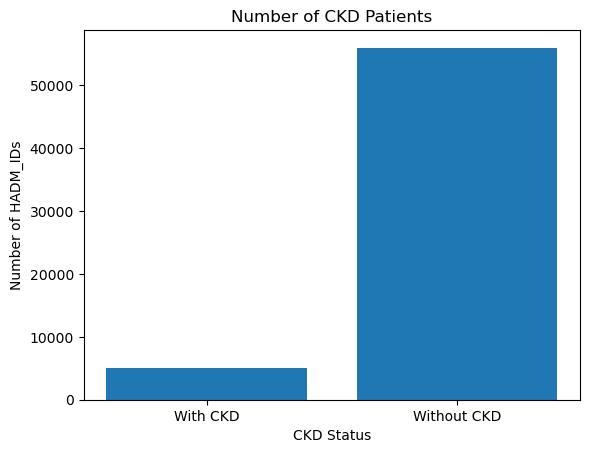

In [74]:
num_with_ckd = icustay_details['CKD'].sum()
num_without_ckd = len(icustay_details) - num_with_ckd

plt.title('Number of CKD Patients')
plt.bar(['With CKD', 'Without CKD'], [num_with_ckd, num_without_ckd])
plt.xlabel('CKD Status')
plt.ylabel('Number of HADM_IDs')
plt.show()

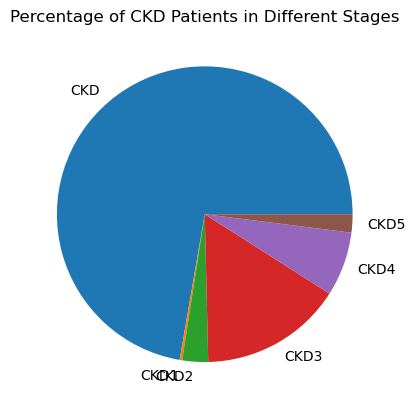

In [75]:
ckd_stages = icustay_details.loc[icustay_details['CKD'] == True].groupby('CKD_stage')['hadm_id'].nunique()

plt.pie(ckd_stages.values, labels=ckd_stages.index)
plt.title('Percentage of CKD Patients in Different Stages')
plt.show()

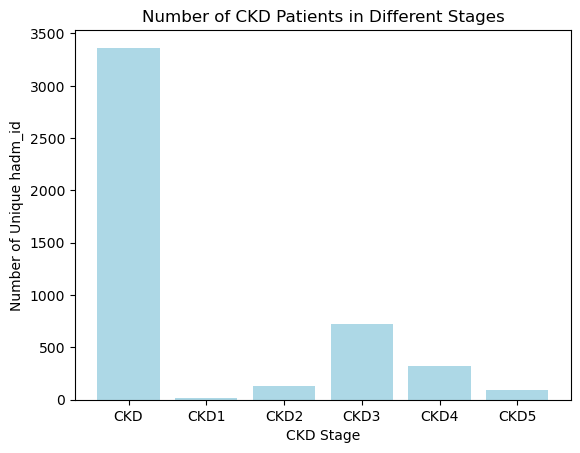

In [76]:
ckd_stages = icustay_details.loc[icustay_details['CKD'] == True].groupby('CKD_stage')['hadm_id'].nunique()
plt.bar(ckd_stages.index, ckd_stages.values, color='lightblue')
plt.title('Number of CKD Patients in Different Stages')
plt.xlabel('CKD Stage')
plt.ylabel('Number of Unique hadm_id')
plt.show()

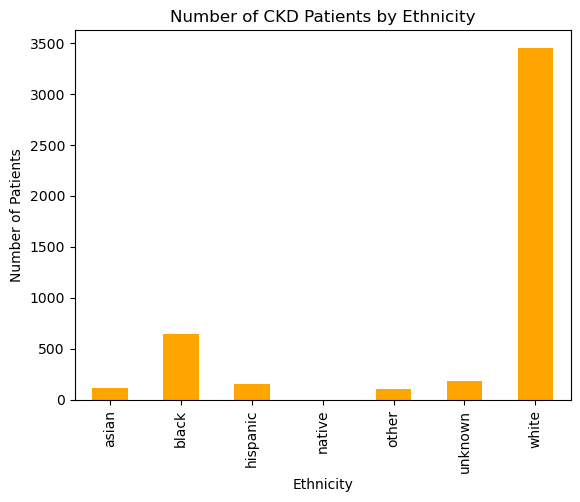

In [77]:
ckd_ethnicity = icustay_details[icustay_details['CKD']==True].groupby('ethnicity_grouped')['hadm_id'].nunique()
ckd_ethnicity.plot(kind='bar', title='Number of CKD Patients by Ethnicity',color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Patients')
plt.show()

In [78]:
ckd_patients = icustay_details.loc[icustay_details['CKD'] == True]
ckd_counts = ckd_patients['ethnicity_grouped'].value_counts()
print(ckd_counts)

white       3761
black        701
unknown      200
hispanic     161
asian        120
other        113
native         2
Name: ethnicity_grouped, dtype: int64


<AxesSubplot:xlabel='CKD_stage'>

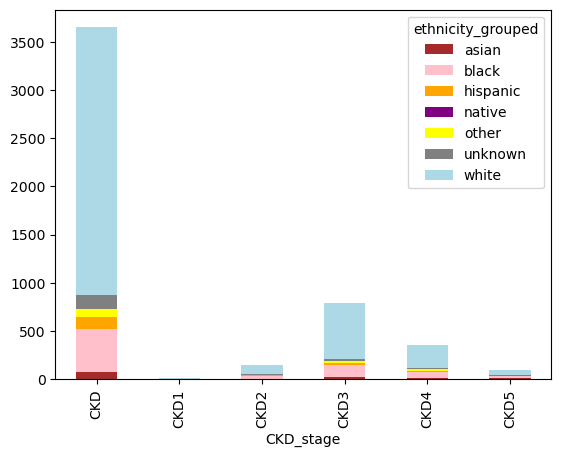

In [79]:
ckd_df = icustay_details[['hadm_id', 'CKD', 'CKD_stage', 'ethnicity_grouped']]
ckd_counts = ckd_df.groupby(['ethnicity_grouped', 'CKD_stage'])['hadm_id'].count()
ckd_counts = ckd_counts.reset_index(name='count')
ckd_counts = ckd_counts.pivot(index='CKD_stage', columns='ethnicity_grouped', values='count')
ckd_counts.plot(kind='bar', stacked=True,color=['brown', 'pink', 'orange', 'purple','yellow','grey','lightblue'])

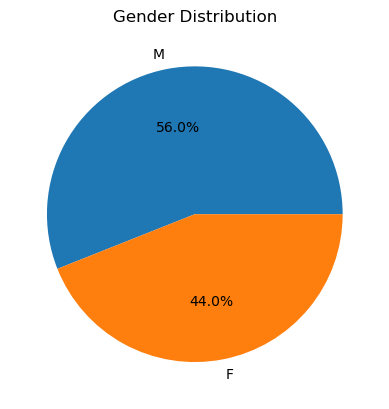

In [80]:
gender_counts = icustay_details['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

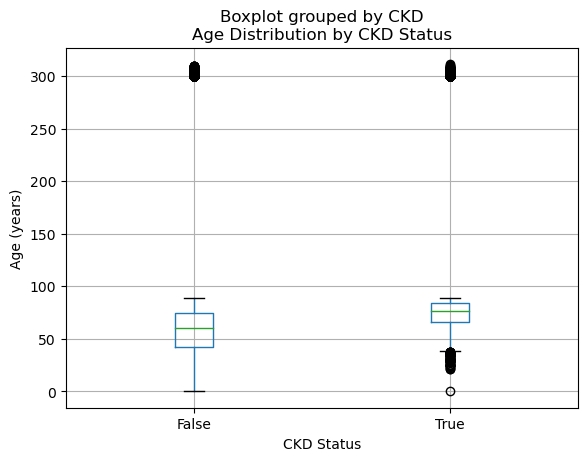

In [81]:
icustay_details.boxplot(column='admission_age', by='CKD')
plt.title('Age Distribution by CKD Status')
plt.xlabel('CKD Status')
plt.ylabel('Age (years)')
plt.show()

PIVOTED VITALS

In [61]:
pivoted_lab = pd.read_sql_query("SELECT * FROM mimiciii.flicu_pivoted_lab;", conn)
pivoted_vital = pd.read_sql_query("SELECT * FROM mimiciii.pivoted_vital;", conn)
cur.close()
conn.close()

C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\aakru\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [83]:
pivoted_vital.head(5)

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose
0,200001,2181-11-25 19:06:00,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200001,2181-11-25 19:07:00,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN
2,200001,2181-11-25 19:08:00,NaN,113.0,65.0,77.0,NaN,NaN,NaN,NaN
3,200001,2181-11-25 19:14:00,NaN,NaN,NaN,NaN,NaN,NaN,94.0,NaN
4,200001,2181-11-25 19:16:00,114.0,NaN,NaN,NaN,26.0,37.277778,95.0,NaN


In [86]:
merged_df = pd.merge(icustay_details, pivoted_vital, on='icustay_id')
ckd_df = merged_df.loc[merged_df['CKD'] == True]
vital_signs = [col for col in pivoted_vital.columns if col not in ['subject_id', 'hadm_id', 'icustay_id', 'charttime']]
ckd_vital_avg = ckd_df.groupby('CKD_stage')[vital_signs].mean()
ckd_vital_std = ckd_df.groupby('CKD_stage')[vital_signs].std()
non_ckd_df = merged_df.loc[merged_df['CKD'] == False]
non_ckd_vital_avg = non_ckd_df.groupby('CKD_stage')[vital_signs].mean()
non_ckd_vital_std = non_ckd_df.groupby('CKD_stage')[vital_signs].std()
ckd_vital_avg = ckd_df.groupby('CKD_stage')[vital_signs].mean()
ckd_vital_std = ckd_df.groupby('CKD_stage')[vital_signs].std()
non_ckd_df = merged_df.loc[merged_df['CKD'] == False]
non_ckd_vital_avg = non_ckd_df.groupby('CKD_stage')[vital_signs].mean()
non_ckd_vital_std = non_ckd_df.groupby('CKD_stage')[vital_signs].std()

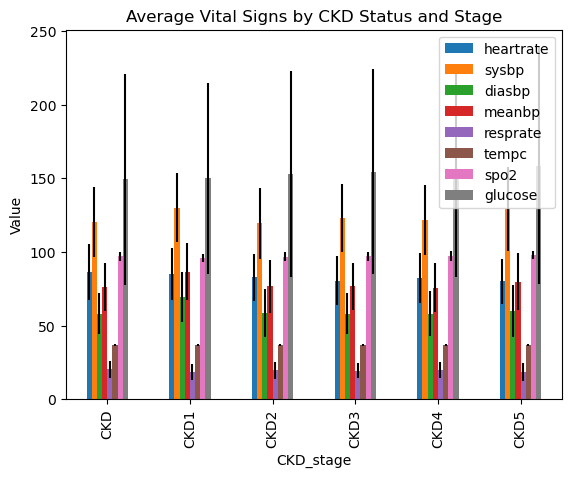

In [90]:
ckd_vital_avg.plot(kind='bar', yerr=ckd_vital_std)
plt.title('Average Vital Signs by CKD Status and Stage')
plt.ylabel('Value')
plt.show()

In [89]:
non_ckd_df.head(5)

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity_grouped,...,CKD_stage,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose
0,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,3.863889,0.002434,asian,...,None,2138-07-17 20:20:00,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,3.863889,0.002434,asian,...,None,2138-07-17 20:30:00,131.0,NaN,NaN,NaN,NaN,NaN,NaN,72.0
2,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,3.863889,0.002434,asian,...,None,2138-07-17 21:00:00,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,3.863889,0.002434,asian,...,None,2138-07-17 22:00:00,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,145834,211552,M,2102-06-14,2101-10-20 19:08:00,2101-10-31 13:58:00,10.784722,76.526792,white,...,None,2101-10-20 18:30:00,NaN,NaN,NaN,NaN,NaN,36.055556,NaN,NaN


In [98]:
vital = pivoted_vital.merge(pivoted_lab[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", vital['icustay_id'].nunique())
lab= pivoted_lab.merge(pivoted_vital[['icustay_id', 'charttime']], on=['icustay_id', 'charttime'], how='outer').drop_duplicates()
print("Number of ICU stays in lab_filtered: ", lab['icustay_id'].nunique())

Number of ICU stays in lab_filtered:  60847
Number of ICU stays in lab_filtered:  60847


In [99]:
vital_resampled = vital.copy()

# Resample from the end of the time series (how="last")
vital_resampled = vital_resampled.assign(charttime=vital_resampled.charttime.dt.round('H'))
#vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
# Resample from the beginning of the time series
vital_resampled = vital_resampled.set_index('charttime').groupby('icustay_id').resample('1H', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use lambda function instead of directly applying it to groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1)
vital_col = vital_resampled.columns.drop(['icustay_id', 'charttime'])
vital_resampled = vital_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[vital_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()
#.fillna(value=vital_resampled[vital_columns].mean()) #.fillna(0)#.fillna(-1)



NameError: name 'vital_filtered' is not defined

In [100]:
lab_resampled = lab.copy()
# Cut out minutes and hours, so that the resampling of the 8h takes the same time span as the 1h samples (for vitals)
lab_resampled = lab_resampled.assign(charttime=lab_resampled.charttime.dt.round('H'))
# Resample from the end of the time series 
#lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="end").median().drop(['icustay_id'], axis = 1).reset_index()
lab_resampled = lab_resampled.set_index('charttime').groupby('icustay_id').resample('8h', origin="start").median().drop(['icustay_id'], axis = 1).reset_index()

# Forward and backwards fill (use transform instead of direct groupby otherwise results from one group are carreid forward to another group...BAD)
# Fill NaNs (-1 or 0 or mean!?)
lab_col = lab_resampled.columns.drop(['icustay_id', 'charttime'])
lab_resampled = lab_resampled.set_index(['icustay_id', 'charttime']).groupby('icustay_id')[lab_col].transform(lambda x: x.ffill().bfill()).fillna(-1).reset_index()


In [101]:
vital_resampled.head(5)

,icustay_id,charttime,heartrate,sysbp,diasbp,meanbp,resprate,tempc,spo2,glucose
0,200001.0,2181-11-25 19:00:00,114.5,113.0,65.0,77.0,24.0,37.277778,94.5,118.0
1,200001.0,2181-11-25 20:00:00,113.0,110.0,65.0,76.0,20.0,37.277778,97.0,118.0
2,200001.0,2181-11-25 21:00:00,108.0,113.0,68.0,79.0,18.0,37.277778,98.0,118.0
3,200001.0,2181-11-25 22:00:00,110.0,116.0,68.0,79.0,27.0,37.277778,98.0,118.0
4,200001.0,2181-11-25 23:00:00,102.0,102.0,61.0,71.0,21.0,37.666667,96.0,118.0


In [118]:
vital_resampled.isna().sum()

icustay_id    0
charttime     0
heartrate     0
sysbp         0
diasbp        0
meanbp        0
resprate      0
tempc         0
spo2          0
glucose       0
dtype: int64

In [102]:
lab_resampled.head(5)

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,hemoglobin,lactate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,200001.0,2181-11-25 19:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,7.3,1.4,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8
1,200001.0,2181-11-26 03:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,7.3,1.4,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8
2,200001.0,2181-11-26 11:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,7.3,1.4,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8
3,200001.0,2181-11-26 19:00:00,55973.0,14.0,-1.0,-1.0,28.0,0.2,2.7,101.0,...,7.3,1.4,128.0,4.3,40.6,2.5,26.1,139.0,83.0,2.8
4,200001.0,2181-11-27 03:00:00,55973.0,17.0,-1.0,-1.0,22.0,0.2,3.5,97.0,...,7.6,1.4,155.0,5.0,40.6,3.8,39.1,131.0,96.0,3.5


In [119]:
lab_resampled.isna().sum()

icustay_id     0
charttime      0
subject_id     0
aniongap       0
albumin        0
bands          0
bicarbonate    0
bilirubin      0
creatinine     0
chloride       0
glucose        0
hematocrit     0
hemoglobin     0
lactate        0
platelet       0
potassium      0
ptt            0
inr            0
pt             0
sodium         0
bun            0
wbc            0
dtype: int64

In [120]:
lab_resampled[lab_resampled['icustay_id']==243653]

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,hemoglobin,lactate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
396911,243653.0,2138-07-17 20:00:00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [121]:
lab_resampled[lab_resampled['icustay_id']==294232]

,icustay_id,charttime,subject_id,aniongap,albumin,bands,bicarbonate,bilirubin,creatinine,chloride,...,hemoglobin,lactate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
870150,294232.0,2173-12-16 03:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,9.3,-1.0,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5
870151,294232.0,2173-12-16 11:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,9.3,-1.0,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5
870152,294232.0,2173-12-16 19:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,9.3,-1.0,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5
870153,294232.0,2173-12-17 03:00:00,68.0,16.0,2.2,-1.0,22.0,0.3,2.5,106.0,...,9.3,-1.0,284.0,5.5,-1.0,-1.0,-1.0,138.0,28.0,2.5
870154,294232.0,2173-12-17 11:00:00,68.0,15.0,2.2,-1.0,20.0,0.3,2.7,106.0,...,9.2,-1.0,273.0,4.8,-1.0,-1.0,-1.0,136.0,25.0,2.9
870155,294232.0,2173-12-17 19:00:00,68.0,14.0,2.2,-1.0,20.0,0.3,2.8,108.0,...,9.2,-1.0,273.0,4.8,-1.0,-1.0,-1.0,137.0,25.0,2.9
870156,294232.0,2173-12-18 03:00:00,68.0,17.0,2.2,-1.0,19.0,0.3,2.9,107.0,...,8.3,-1.0,214.0,4.5,-1.0,-1.0,-1.0,138.0,25.0,1.8
870157,294232.0,2173-12-18 11:00:00,68.0,17.0,2.2,-1.0,19.0,0.3,2.9,107.0,...,8.3,-1.0,214.0,4.5,-1.0,-1.0,-1.0,138.0,25.0,1.8
870158,294232.0,2173-12-18 19:00:00,68.0,17.0,2.2,-1.0,19.0,0.3,2.9,107.0,...,8.3,-1.0,214.0,4.5,-1.0,-1.0,-1.0,138.0,25.0,1.8
870159,294232.0,2173-12-19 03:00:00,68.0,15.0,2.2,-1.0,19.0,0.3,3.0,105.0,...,8.0,-1.0,211.0,3.9,-1.0,-1.0,-1.0,135.0,27.0,1.8


In [105]:
# Filter icustay_detail to include only CKD patients
ckd_patients = icustay_details[icustay_details['CKD'] == True]['icustay_id']

# Filter vital_resampled and lab_resampled to include only CKD patients
vital_ckd = vital_resampled[vital_resampled['icustay_id'].isin(ckd_patients)]
lab_ckd = lab_resampled[lab_resampled['icustay_id'].isin(ckd_patients)]

In [107]:
ckd_patients.head(5)

71     294232
72     225771
73     272667
89     291697
126    221610
Name: icustay_id, dtype: int64

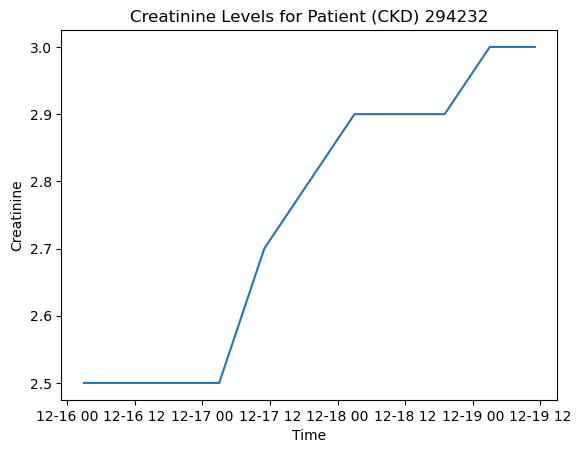

In [132]:
ckd_data = lab_ckd.merge(vital_ckd, on=['icustay_id', 'charttime'], how='outer')
creatinine_data = ckd_data[['icustay_id', 'charttime', 'creatinine']]
# Select data for a single patient
patient_data = creatinine_data[creatinine_data['icustay_id'] == 294232]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (CKD) {}'.format(294232))
plt.show()

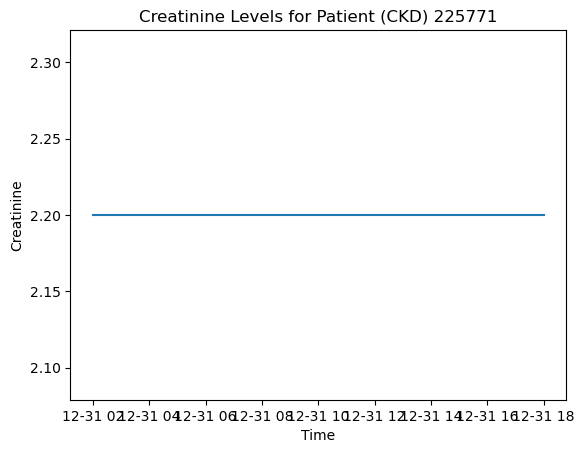

In [133]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 225771]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (CKD) {}'.format(225771))
plt.show()

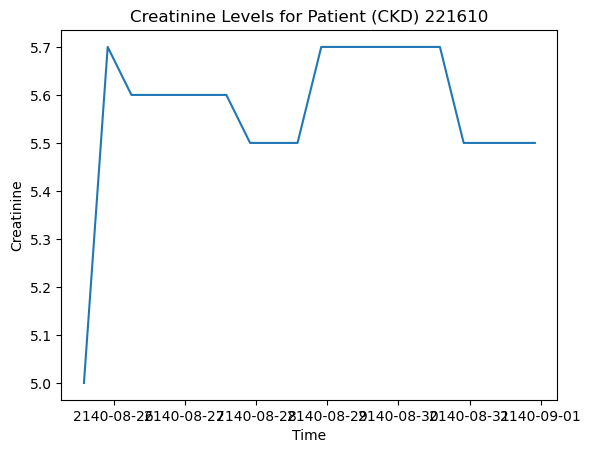

In [134]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 221610]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (CKD) {}'.format(221610))
plt.show()

In [110]:
nonckd_patients = icustay_details[icustay_details['CKD'] ==False]['icustay_id']
vital_nonckd = vital_resampled[vital_resampled['icustay_id'].isin(nonckd_patients)]
lab_nonckd = lab_resampled[lab_resampled['icustay_id'].isin(nonckd_patients)]

In [111]:
nonckd_patients.head(5)

0    243653
1    211552
2    294638
3    214757
4    228232
Name: icustay_id, dtype: int64

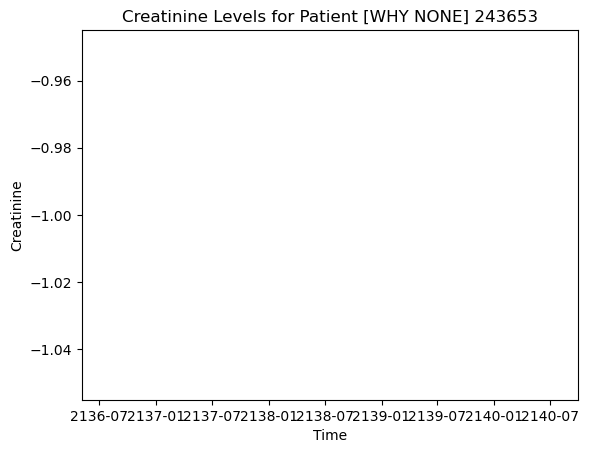

In [116]:
nonckd_data = lab_nonckd.merge(vital_nonckd, on=['icustay_id', 'charttime'], how='outer')
creatinine_data = nonckd_data[['icustay_id', 'charttime', 'creatinine']]
# Select data for a single patient
patient_data = creatinine_data[creatinine_data['icustay_id'] == 243653]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient [WHY NONE] {}'.format(243653))
plt.show()

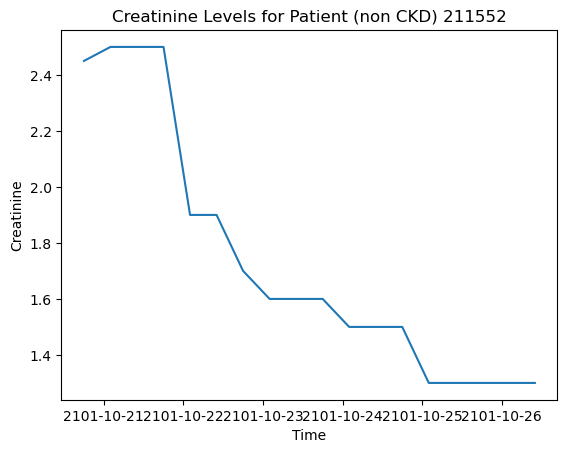

In [130]:
patient_data = creatinine_data[creatinine_data['icustay_id'] ==211552]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (non CKD) {}'.format(211552))
plt.show()

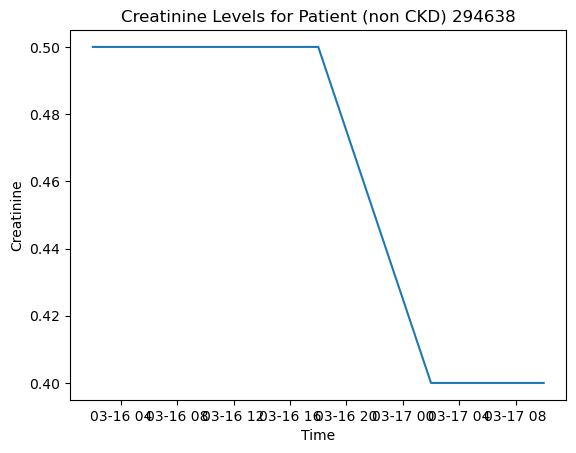

In [131]:
patient_data = creatinine_data[creatinine_data['icustay_id'] ==294638]

# Create a time series plot
plt.plot(patient_data['charttime'], patient_data['creatinine'])
plt.xlabel('Time')
plt.ylabel('Creatinine')
plt.title('Creatinine Levels for Patient (non CKD) {}'.format(294638))
plt.show()

In [129]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 211552]
patient_data

,icustay_id,charttime,creatinine
98170,211552.0,2101-10-20 18:00:00,2.45
98171,211552.0,2101-10-21 02:00:00,2.50
98172,211552.0,2101-10-21 10:00:00,2.50
98173,211552.0,2101-10-21 18:00:00,2.50
98174,211552.0,2101-10-22 02:00:00,1.90
...,...,...,...
1518820,211552.0,2101-10-26 13:00:00,NaN
1518821,211552.0,2101-10-26 14:00:00,NaN
1518822,211552.0,2101-10-26 15:00:00,NaN
1518823,211552.0,2101-10-26 16:00:00,NaN


In [117]:
patient_data = creatinine_data[creatinine_data['icustay_id'] == 243653]
patient_data

,icustay_id,charttime,creatinine
370711,243653.0,2138-07-17 20:00:00,-1.0
3359941,243653.0,2138-07-17 21:00:00,NaN
3359942,243653.0,2138-07-17 22:00:00,NaN


ICU stay duration/length for CKD patients

C:\Users\aakru\AppData\Local\Temp\ipykernel_9224\1004732647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ckd_icustay_detail['los'] = ckd_icustay_detail['outtime'] - ckd_icustay_detail['intime']
C:\Users\aakru\AppData\Local\Temp\ipykernel_9224\1004732647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ckd_icustay_detail['los_hours'] = ckd_icustay_detail['los'].astype('timedelta64[h]')


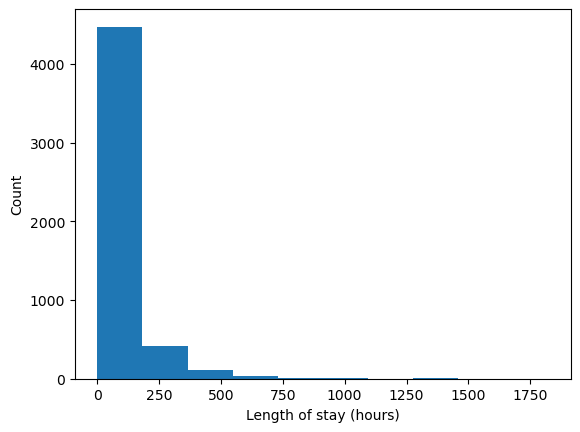

In [128]:
ckd_icustay_detail = icustay_details[icustay_details['icustay_id'].isin(ckd_patients)]
ckd_icustay_detail['los'] = ckd_icustay_detail['outtime'] - ckd_icustay_detail['intime']
ckd_icustay_detail['los_hours'] = ckd_icustay_detail['los'].astype('timedelta64[h]')
plt.hist(ckd_icustay_detail['los_hours'])
plt.xlabel('Length of stay (hours)')
plt.ylabel('Count')
plt.show()